In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Statistics

In [3]:
n_x = 1001
phases = range(-1.0, 1.0, n_x) |> collect;

In [4]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [5]:
function spike_current(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)
    #get constants
    t_window = spk_args.t_window
    dt = spk_args.dt

    #find which channels are active 
    times = train.times
    active = (times .> (t - sigma * t_window)) .* (times .< (t + sigma * t_window))
    active_inds = train.indices[active]

    #add currents into the active synapses
    current_kernel = x -> exp(-1 * (t - x)^2 / (2 * t_window))
    impulses = current_kernel.(train.times[active])
    
    current = zeros(Float32, train.shape)
    current[active_inds] .+= impulses

    return current
end

spike_current (generic function with 1 method)

In [6]:
function phase_memory(x::SpikeTrain; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args())
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)

    #set up compartments for each sample
    u0 = zeros(ComplexF32, x.shape)
    #resonate in time with the input spikes
    dzdt(u, p, t) = k .* u .+ spike_current(x, t, spk_args)
    #solve the memory compartment
    prob = ODEProblem(dzdt, u0, tspan)
    sol = solve(prob, spk_args.solver, adaptive=true, abstol = 1e-6, reltol = 1e-6,)

    return sol
end

phase_memory (generic function with 1 method)

In [7]:
spk_args = SpikingArgs(t_window=0.01, dt = 0.001, solver = Tsit5())

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [8]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [9]:
tbase = collect(tspan[1]:spk_args.dt:tspan[2]);

In [11]:
st = phase_to_train(phases, spk_args=spk_args, repeats = repeats)

Spike Train: (1001,) with 6006 spikes.

In [12]:
u = phase_memory(st, tspan=tspan, spk_args=spk_args);

In [13]:
u |> size

(1001, 5109)

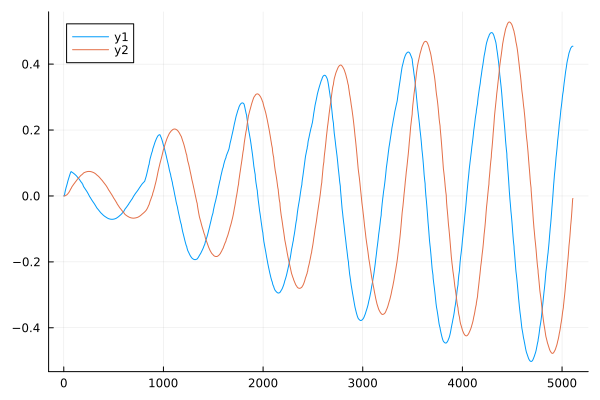

In [15]:
plot(real.(u[1,:]))
plot!(imag.(u[1,:]))

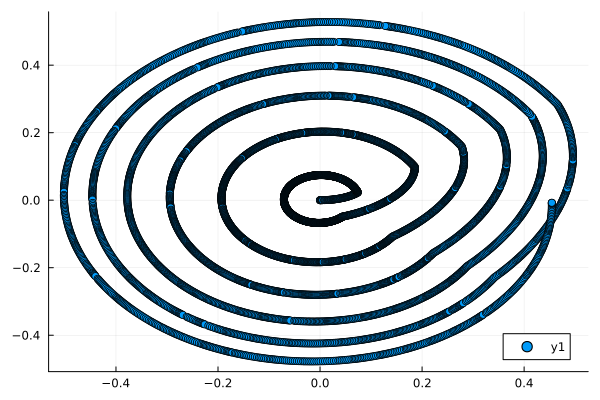

In [16]:
scatter(real.(u[1,:]), imag.(u[1,:]))

In [17]:
sort!(unique(cat(u.t, u.t .+ 0.01, dims=1)))

10218-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.00019415467342268397
 0.0006176402794719296
 0.0018001725795056
 0.0025478997229645326
 0.00339353741608599
 0.00421386663808659
 0.004889997913428191
 0.00788952286194119
 0.009319636615839087
 0.01
 0.0101
 ⋮
 5.999560768443353
 5.999906395338963
 6.0
 6.000558128826825
 6.002204902584921
 6.003869909707759
 6.005587414661916
 6.007323214025036
 6.0086572137945575
 6.009560768443353
 6.009906395338962
 6.01

In [18]:
Array(u(u.t))

1001×5109 Matrix{ComplexF64}:
 0.0+0.0im  9.99989e-5+3.14154e-8im  …  0.454272-0.00759007im
 0.0+0.0im  9.99944e-5+3.1414e-8im       0.45391-0.0101909im
 0.0+0.0im  9.99799e-5+3.14094e-8im     0.454679-0.0130645im
 0.0+0.0im  9.99554e-5+3.14017e-8im     0.454567-0.0161178im
 0.0+0.0im  9.99209e-5+3.13907e-8im     0.455394-0.0188782im
 0.0+0.0im  9.98765e-5+3.13766e-8im  …    0.4555-0.0216663im
 0.0+0.0im   9.9822e-5+3.13596e-8im     0.455418-0.0245953im
 0.0+0.0im  9.97577e-5+3.13393e-8im     0.455592-0.0274877im
 0.0+0.0im  9.96834e-5+3.13159e-8im     0.455964-0.0304874im
 0.0+0.0im  9.95992e-5+3.12894e-8im     0.456422-0.0333765im
 0.0+0.0im  9.95051e-5+3.12598e-8im  …  0.456397-0.0362367im
 0.0+0.0im  9.94012e-5+3.12272e-8im     0.456485-0.0389508im
 0.0+0.0im  9.92874e-5+3.11913e-8im     0.456599-0.0418254im
    ⋮                                ⋱  
 0.0+0.0im         0.0+0.0im            0.513006+0.054028im
 0.0+0.0im         0.0+0.0im         …  0.512719+0.0509663im
 0.0+0.0im    

In [19]:
typeof(u)

ODESolution{ComplexF32, 2, Vector{Vector{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF32}}}, ODEProblem{Vector{ComplexF32}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt#5"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt#5"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSER

In [20]:
u_arr = Array(u);

In [21]:
size(u_arr)

(1001, 5109)

In [22]:
p_rec = potential_to_phase(u_arr, u.t, dim=2, spk_args=spk_args);

In [23]:
size(p_rec)

(1001, 5109)

In [24]:
err = p_rec[:,end] .- phases;

In [25]:
size(err)

(1001,)

In [26]:
mean(err)

0.00044973591194212787

In [27]:
median(err)

0.0009057144169941633

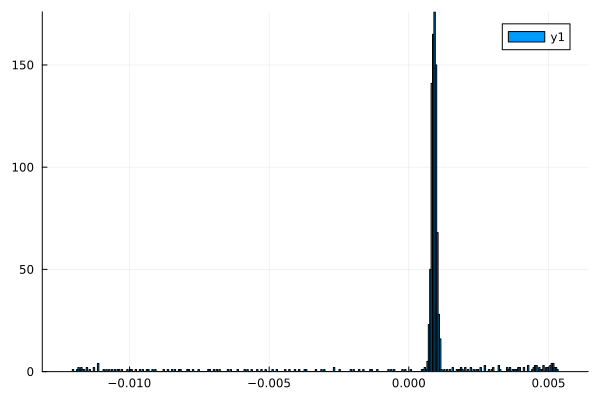

In [28]:
histogram(err)

In [29]:
ang_err = sin.(pi .* err);

In [30]:
median(ang_err)

0.002845381919202544

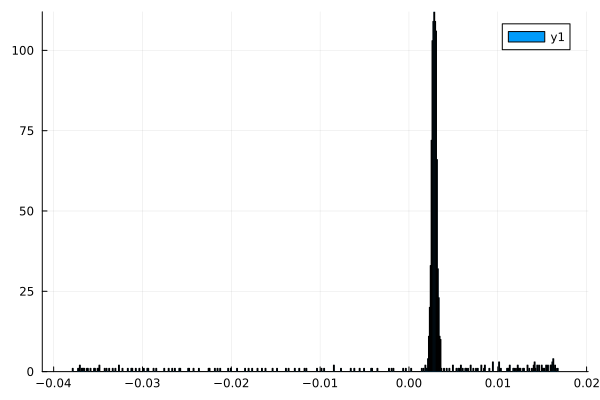

In [31]:
histogram(ang_err)

In [32]:
import .PhasorNetworks: find_spikes_rf

In [33]:
spk_i, spk_t = find_spikes_rf(u, spk_args)

(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(741,), CartesianIndex(742,), CartesianIndex(743,), CartesianIndex(744,), CartesianIndex(745,), CartesianIndex(746,), CartesianIndex(747,), CartesianIndex(748,), CartesianIndex(749,), CartesianIndex(750,)], [0.2916962076002611, 0.2916962076002611, 0.29293827773771214, 0.29293827773771214, 0.29293827773771214, 0.2943059773368738, 0.2943059773368738, 0.2943059773368738, 0.29556667632716094, 0.29556667632716094  …  5.988934219183111, 5.990558128826825, 5.9922049025849216, 5.9922049025849216, 5.993869909707759, 5.993869909707759, 5.995587414661916, 5.9973232140250365, 5.9973232140250365, 5.998657213794558])

In [34]:
st = SpikeTrain(spk_i, spk_t, (1001,), 0.25)

Spike Train: (1001,) with 5755 spikes.

In [40]:
spks1 = findall(x -> x == st.indices[1], st.indices)

6-element Vector{Int64}:
    1
 1002
 2003
 3004
 4005
 5006

In [41]:
tms1 = st.times[spks1]

6-element Vector{Float64}:
 0.2916962076002611
 1.2629887896394634
 2.2559382101567698
 3.2545719202932806
 4.252651113525181
 5.2521308477048745

In [42]:
phases[1]

-1.0

In [35]:
stp = train_to_phase(st, spk_args)

6×1001 Matrix{Float64}:
 -0.916608  -0.916608  -0.914123  …    0.99709     0.99709     0.999435
 -0.974022  -0.974022  -0.971519       0.996429    0.997723    0.997723
 -0.988124  -0.985191  -0.982287       0.995251    0.997919  NaN
 -0.990856  -0.990856  -0.988059       0.993935    0.9969      0.999669
 -0.994698  -0.992595  -0.990388       0.994394    0.99727     0.999435
 -0.995738  -0.993328  -0.993328  …  NaN         NaN         NaN

In [36]:
spk_err = stp[end-1,:] .- phases;

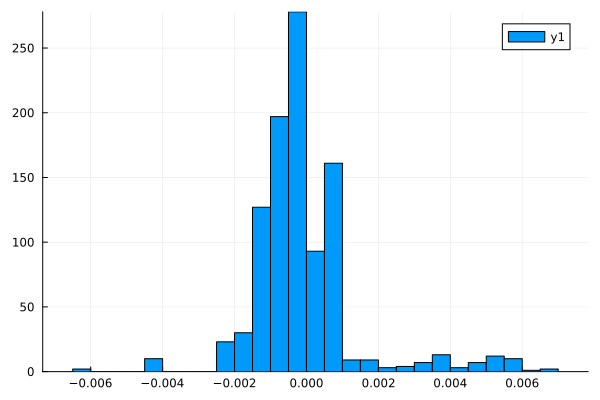

In [37]:
histogram(spk_err)